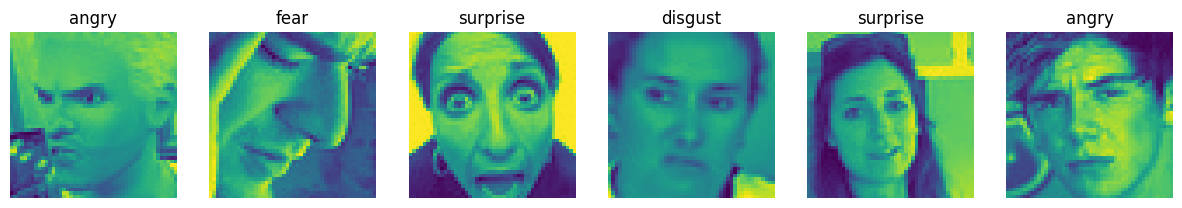

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

def visualize_raw_samples(directory, n=6):
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        label = random.choice(os.listdir(directory))
        image_file = random.choice(os.listdir(os.path.join(directory, label)))
        image_path = os.path.join(directory, label, image_file)
        image = Image.open(image_path)
        
        axs[i].imshow(image)
        axs[i].set_title(label)
        axs[i].axis('off')

directory_path = '/kaggle/input/fer2013/train/'
visualize_raw_samples(directory_path)


In [18]:
import os
from collections import Counter

def analyze_label_distribution(directory):
    labels = []
    for label in os.listdir(directory):
        images = os.listdir(os.path.join(directory, label))
        labels.extend([label] * len(images))
    
    label_counts = Counter(labels)
    return label_counts

directory_path = '/kaggle/input/fer2013/train/'
label_distribution = analyze_label_distribution(directory_path)
print(label_distribution)


Counter({'happy': 7215, 'neutral': 4965, 'sad': 4830, 'fear': 4097, 'angry': 3995, 'surprise': 3171, 'disgust': 436})


In [19]:
# from PIL import Image

# def find_corrupt_images(directory):
#     corrupt_files = []
#     for label in os.listdir(directory):
#         image_files = os.listdir(os.path.join(directory, label))
#         for image_file in image_files:
#             try:
#                 with Image.open(os.path.join(directory, label, image_file)) as img:
#                     img.verify()
#             except (IOError, SyntaxError) as e:
#                 corrupt_files.append(os.path.join(directory, label, image_file))
#     return corrupt_files

# directory_path = '/kaggle/input/fer2013/train/'
# corrupt_images = find_corrupt_images(directory_path)
# print(f"Found {len(corrupt_images)} corrupt images")


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split

class FacialExpressionsDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = []
        self.labels = []

        for label in os.listdir(directory):
            for image_file in glob.glob(os.path.join(directory, label, '*.jpg')):
                self.images.append(image_file)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        label_to_idx = {'happy': 0, 'sad': 1, 'angry': 2, 'disgust': 3, 'fear': 4, 'surprise': 5, 'neutral': 6}
        label_idx = label_to_idx[label]

        return image, label_idx
# mu, st = 0, 255

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ),(0.5, ))
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ),(0.5, ))
])
# train_transform = transforms.Compose([
#             transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
#             transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),

# #             transforms.TenCrop(40),
#             transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
#             transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
#             transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
# ])

# test_transform =   test_transform = transforms.Compose([
#         # transforms.Scale(52),
#         transforms.TenCrop(40),
#         transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
#         transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
#     ])
train_dataset = FacialExpressionsDataset(directory='/kaggle/input/fer2013/train/', transform=transform)
test_dataset = FacialExpressionsDataset(directory='/kaggle/input/fer2013/test/', transform=test_transform)


val_size = int(len(train_dataset) * 0.1)
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=24, shuffle=False, drop_last=True)
val_loader = DataLoader(val_data, batch_size=24, shuffle=False, drop_last=True)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.bias = bias
        
        # Attention mechanism
        self.weights = nn.Parameter(torch.Tensor(128, 1))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(1))
        else:
            self.register_parameter('bias', None)
        
        self.activation = nn.Tanh()

        self.reset_parameters()

    def reset_parameters(self):
#         nn.init.uniform_(self.weights, -0.1, 0.1)
#         if self.bias is not None:
#             nn.init.constant_(self.bias, 0.0)
        # Xavier initialization
        nn.init.xavier_uniform_(self.weights)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0.0)

    def forward(self, x, mask=None):
        # x shape: (batch_size, time_steps, features)
        batch_size, time_steps, features= x.shape
        
        # Compute attention scores
        e = torch.matmul(x, self.weights)  # (batch_size, time_steps, 1)
        e = e.squeeze(2) + self.bias  # Remove the last dimension and add bias
        e = self.activation(e)  # Apply activation function
#         print('-----------------------------------------e')
#         print(e)
        # Softmax to get attention weights
        a = torch.softmax(e, dim=1)  # (batch_size, time_steps)

        # Apply mask, if any
        if mask is not None:
            a = a * mask
            a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        # Compute the weighted sum of the inputs
        a = a.unsqueeze(2)  # Reshape for broadcasting (batch_size, time_steps, 1)
#         print('-----------------------------------------------a')
#         print(a)
        weighted_input = x * a  # (batch_size, time_steps, features)
        attended_output = torch.sum(weighted_input, 1)  # (batch_size, features)

        return attended_output, a


In [22]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 16 00:12:24 2020

@author: NAT
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'VGG8':  [64, 'M', 128, 'M', 256, 256, 'M', 512, 'M']  # VGG8 configuration

}


class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes, input_size, hidden_size, num_layers):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 7)
        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        
#         self.attention = Attention(128, 1)
        self.attention = Attention(128, 48)

        # Fusion and fully connected layers
        self.fusion_size = 512 + hidden_size  # VGG features size (512) + LSTM attended features size
        self.dense1 = nn.Linear(128, 64)
        self.dense2 = nn.Linear(self.fusion_size, 128)

        self.relu = nn.ReLU()
        self.output = nn.Linear(64, num_classes)
        self.output1 = nn.Linear(128, num_classes)

    def forward(self, x):

        vgg_features = self.features(x)
#         print(vgg_features.size())
        vgg_output = vgg_features.view(vgg_features.size(0), -1)
#         print(vgg_features.size())
        vgg_features = vgg_features.view(24, 32, -1)
#         print(vgg_features.size())
#         input_size = vgg_features.size(-1)  # Size of the input feature vector
#         print(input_size)


#         images = x.view(24, 48, 48).float().cuda()
        output, (hidden, cell) = self.lstm(vgg_features)
#         print(output.size())
        out, attn = self.attention(output)
        hdense = self.relu(self.dense1(out))
        x = self.output(hdense)
#         print(vgg_features.size(), out.size())
#         fused_features = torch.cat((vgg_output, out), dim=1)

#         hdense = self.relu(self.dense2(fused_features))
#         x = self.output1(hdense)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 1
        
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#                            nn.Dropout(0.2)]  
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha if alpha is not None else 1.0  # Ensure alpha is either a tensor or scalar
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)

        # Convert targets to long if it's not already to ensure it can be used for indexing
        targets = targets.long()

        if isinstance(self.alpha, torch.Tensor):
            alpha_factor = self.alpha[targets]  # Use indexed alpha values if alpha is a tensor
        else:
            alpha_factor = self.alpha  # Use scalar alpha if alpha is a scalar

        # Apply focal loss formula
        focal_loss = (alpha_factor * (1 - pt) ** self.gamma * ce_loss)

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss



In [24]:
def to_one_hot(targets, num_classes):
    evice = targets.device
    return torch.eye(num_classes, device='cuda')[targets]

In [25]:
num_classes = 7
input_size = 16
hidden_size = 128
num_layers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG('VGG11', num_classes, input_size, hidden_size, num_layers).to(device)
alpha = torch.tensor([1.0, 1.2 ,1.1,1.3, 1.1,1.0,1.1]).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(gamma=2.0, alpha=alpha)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay = 0.001)


In [26]:
# pip install torchinfo

In [27]:

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [28]:
# from torchinfo import summary

# # Assume 'model' is your PyTorch model and 'device' is your device (either 'cuda' or 'cpu')
# model.to(device)
# summary(model, input_size=(32, 1, 48, 48))


In [29]:
def validate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
#             images = images.view(32, 48, 48).float().cuda() 
            outputs = model(images)
            loss = criterion(outputs, labels)
#             targets_one_hot = to_one_hot(labels, num_classes).to(device)
#             loss = criterion(outputs, targets_one_hot)
            _, predicted = torch.max(outputs, 1)
            
            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(data_loader)
    avg_acc = correct_predictions / total_predictions * 100
    return avg_loss, avg_acc

def train_and_validate_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_accuracy = 0.0
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
#             images = images.view(32, 48, 48).float().cuda()  # Correct reshaping

            optimizer.zero_grad()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_predictions / total_predictions * 100
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        val_loss, val_acc = validate_model(model, criterion, val_loader)
        test_loss, test_acc = validate_model(model, criterion, test_loader)

        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        test_losses.append(test_loss)
        test_accs.append(test_acc)
#         scheduler.step()

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%'
              f'Test loss: {test_loss:4f}, Test acc: {test_acc:.2f}%')

        if test_acc > best_accuracy:
            best_accuracy = test_acc
            torch.save(model.state_dict(), 'best_model.pth')

    print('Finished Training')
    return train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accs

train_losses, train_accuracies, val_losses, val_accuracies, test_losses, test_accs = train_and_validate_model(
    model, criterion, optimizer, train_loader, val_loader, num_epochs=30)


Epoch 1/30, Train Loss: 1.6175, Train Acc: 34.58%, Val Loss: 1.4720, Val Acc: 41.07%Test loss: 1.428880, Test acc: 41.79%
Epoch 2/30, Train Loss: 1.4237, Train Acc: 43.20%, Val Loss: 1.3734, Val Acc: 46.01%Test loss: 1.346108, Test acc: 46.77%
Epoch 3/30, Train Loss: 1.3376, Train Acc: 47.64%, Val Loss: 1.3127, Val Acc: 49.16%Test loss: 1.272373, Test acc: 50.46%
Epoch 4/30, Train Loss: 1.2668, Train Acc: 50.88%, Val Loss: 1.2396, Val Acc: 51.23%Test loss: 1.229040, Test acc: 51.90%
Epoch 5/30, Train Loss: 1.2209, Train Acc: 53.11%, Val Loss: 1.2313, Val Acc: 51.89%Test loss: 1.238025, Test acc: 52.41%
Epoch 6/30, Train Loss: 1.1945, Train Acc: 54.19%, Val Loss: 1.1858, Val Acc: 55.18%Test loss: 1.186565, Test acc: 53.46%
Epoch 7/30, Train Loss: 1.1595, Train Acc: 55.74%, Val Loss: 1.1551, Val Acc: 55.78%Test loss: 1.169001, Test acc: 55.69%
Epoch 8/30, Train Loss: 1.1321, Train Acc: 57.19%, Val Loss: 1.0915, Val Acc: 59.14%Test loss: 1.121043, Test acc: 57.19%
Epoch 9/30, Train Loss: 

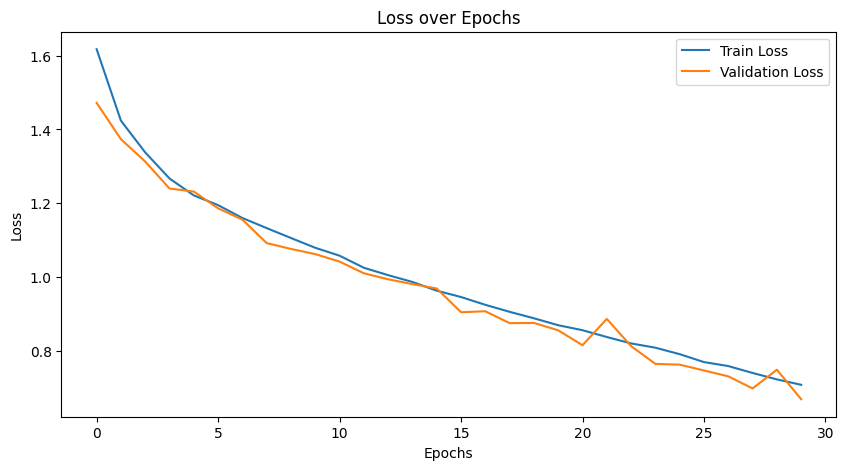

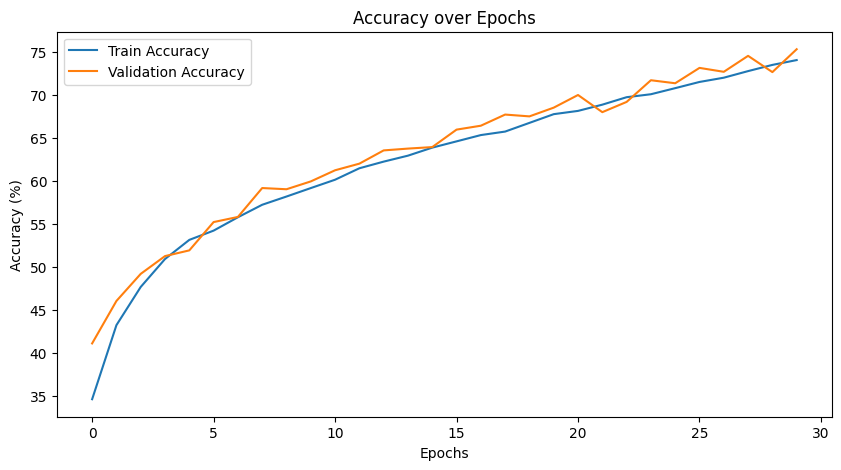

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

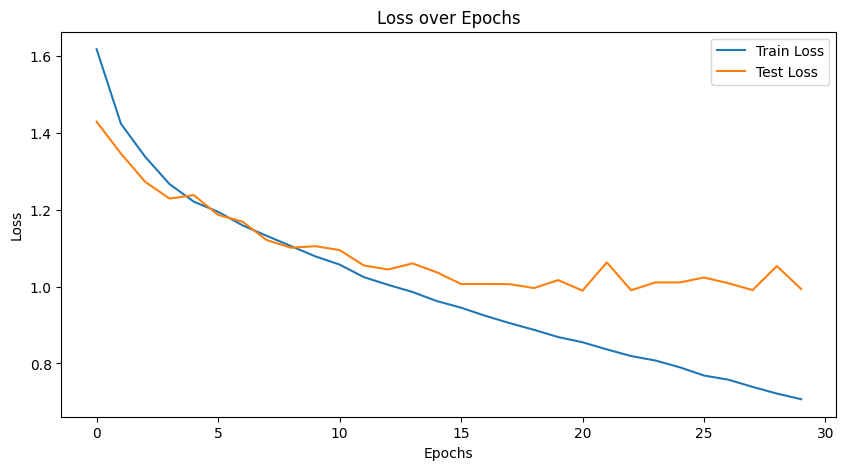

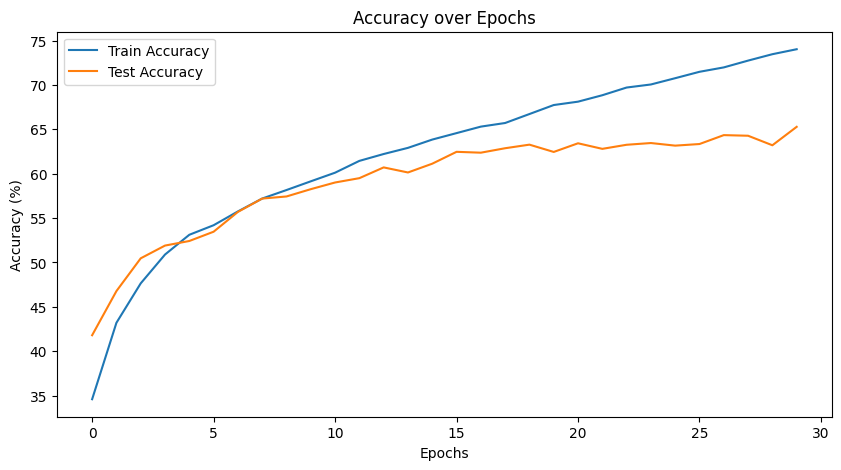

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

Accuracy of the model on the test images: 65.27%


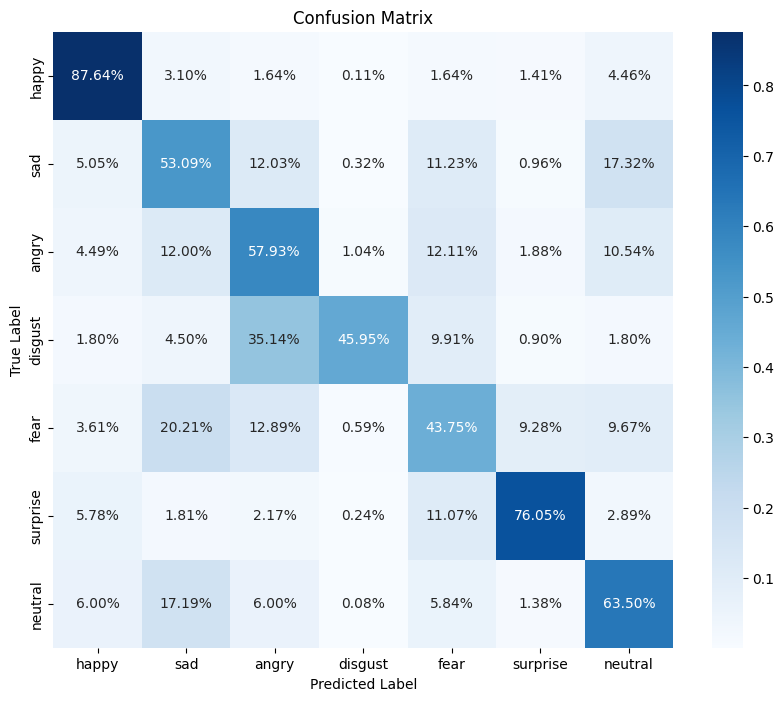

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_on_test(test_loader, model_path='/kaggle/working/best_model.pth'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = VGG('VGG11', num_classes, input_size, hidden_size, num_layers).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predicted.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues', xticklabels=label_to_idx.keys(), yticklabels=label_to_idx.keys())
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Assuming you have a dictionary for class labels
label_to_idx = {'happy': 0, 'sad': 1, 'angry': 2, 'disgust': 3, 'fear': 4, 'surprise': 5, 'neutral': 6}

# Evaluate the model on the test set
evaluate_on_test(test_loader)